# Simulation

## Data and Pipeline Explanation

This notebook documents steps taken to run all simulations.

**Goal**: To compare the power of rare variant aggregate association tests using exome sequencing and imputed dataset

**Data**:
- Exome sequencing: `ES`
- Imputed dataset: `HRC`, `TOPMed`
- Merged dataset: `HRC_TOPMed`, `ES_HRC_TOPMed`
 
**Data Filtering Parameters**:
- MAF： <0.01, <0.005, <0.001
- $R^2$: (imputed dataset only) > 0.3 or 0.8

**Simulation Process**:

1. Generate effect size for the variants within a gene
    - no variant causal -> null
    - all variants causal
    - 50% variants causal
    - 75% variants causal
    
2. Generate phenotype:
$$logit \; p(y_i = 1) = \alpha + \beta G + \epsilon$$
    - $\alpha$ = 0.1, 0.2
    - $\beta$ = log(1.2), log(1.5), log(1.8)
    - $G$ = genetic data
    - $\epsilon$ ~ N(0,1)

3. Sample with replacement for case-control: 40k cases v.s. 60k controls

4. Running BRV

5. Calculate power: proportion of gene reaching exome-wide significant level ($p < 2.5 \times 10^{−6}$)



## Create per gene file

### Exome

In [ ]:
library(dplyr)
setwd("~/project/imputation-rvtest/analysis/imputation_aggregated_analysis/exome")


for(maf in c(0.01, 0.005, 0.001)){
    maf_c <- gsub("\\.", "", as.character(maf))
    
    dir_path <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/gene/exome_maf%s", maf_c)
    if (dir.exists(dir_path)) {
      unlink(file.path(dir_path, "*"), recursive = TRUE)
    } else {
      dir.create(dir_path, recursive = TRUE)
    }
    
    for(i in c(1,2)){
        command_script_fname <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/command_chr%d_maf%s_exome.sh", i, maf_c)
        if(file.exists(command_script_fname)) unlink(command_script_fname)
        
        file.create(command_script_fname)
        fileConn <- file(command_script_fname, "w")
        header_lines <- c(
            "#!/bin/bash",
            "#SBATCH --mem=45G",
            "#SBATCH --time=12:00:00",
            sprintf("#SBATCH --job-name=extract_exome_chr%i_maf%s", i, maf_c),
            sprintf("#SBATCH --output=/home/tl3031/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/extract_exome_chr%i_maf%s.out", i, maf_c),
            sprintf("#SBATCH --error=/home/tl3031/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/extract_exome_chr%i_maf%s.err", i, maf_c),
            "#SBATCH -p CSG",
            "#SBATCH --mail-type=FAIL",
            "#SBATCH --mail-user=tl3031@cumc.columbia.edu",
            "module load Plink/1.9.10"
        )
        writeLines(header_lines, fileConn)
        close(fileConn)
        
        snplist_annot_fname <- sprintf("ukb23156_c%i.merged.filtered.hg38.hg38_multianno_formatted_sel_col_maf%s_LOF_missense.csv.gz", i, maf_c)
        snplist_annot <- data.table::fread(snplist_annot_fname)

        gene_lst <- snplist_annot %>% pull(Gene.refGene) %>% unique()
        print(length(gene_lst)) 
        
        for(g in gene_lst){
            df <- snplist_annot %>% filter(Gene.refGene == g) %>% select(ID_hg38)

            out_fname <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/gene/exome_maf%s/chr%d_%s", maf_c, i, g)
            write.table(df, out_fname, quote = FALSE, row.name = FALSE, col.name = FALSE)
            
            fileConn <- file(command_script_fname, "a")
            command <- sprintf("plink --bfile ~/project/imputation-rvtest/analysis/imputation_aggregated_analysis/exome/ukb23156_c%d_maf001_LOF_missense_extracted \\
                                --extract %s --make-bed --export A --out %s;", i, out_fname, out_fname)
            writeLines(command, fileConn)
            close(fileConn)
        }
    }
}

In [ ]:
library(data.table)
library(dplyr)

format_exome <- function(fname){
    df <- fread(fname)
    df_names <- colnames(df)[7: dim(df)[2]] %>% stringr::str_split(pattern = "_", simplify = TRUE)
    colnames(df)[7:dim(df)[2]] <- df_names[,1]

    df_X <- df %>% arrange(FID, IID) %>% select(-c(1:6)) %>% as.matrix()
    df_X_aggregated <- rowSums(df_X, na.rm=TRUE) %>% as.vector()

    df_out <- df %>% arrange(FID, IID) %>% select(c(1:2)) %>% mutate(aggregate = df_X_aggregated)
    out_fname <- sub("\\.raw$", "_aggregate.txt", fname) 
    fwrite(df_out, out_fname) 
}

for(maf in c(0.01, 0.005, 0.001)){
    maf_c <- gsub("\\.", "", as.character(maf))
    
    print(sprintf("=======Formatting MAF %s=======", maf_c))
    
    dir_path <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/gene/exome_maf%s", maf_c)
    flst <- list.files(dir_path, pattern = ".raw", full.names = TRUE)
    
    for(f in flst){
        format_exome(f)
        if(which(flst == f) %% 100 == 0) print(which(flst == f))
    }
}

### HRC

In [ ]:
setwd("~/project/imputation-rvtest/analysis/imputation_aggregated_analysis/hrc")

for(rsq in c(3, 8)){
    for(maf in c(0.01, 0.005, 0.001)){
        maf_c <- gsub("\\.", "", as.character(maf))
        
        dir_path <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/gene/hrc_rsq0%s_maf%s", rsq, maf_c)
        if (dir.exists(dir_path)) {
          unlink(file.path(dir_path, "*"), recursive = TRUE)
        } else {
          dir.create(dir_path, recursive = TRUE)
        }
        
        for(i in c(1,2)){
            command_script_fname <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/command_chr%d_rsq0%i_maf%s_hrc.sh", i, rsq, maf_c)
            if(file.exists(command_script_fname)) unlink(command_script_fname)
            
            file.create(command_script_fname)
            fileConn <- file(command_script_fname, "w")
            header_lines <- c(
                "#!/bin/bash",
                "#SBATCH --mem=45G",
                "#SBATCH --time=12:00:00",
                sprintf("#SBATCH --job-name=extract_hrc_chr%i_maf%s", i, maf_c),
                sprintf("#SBATCH --output=/home/tl3031/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/extract_hrc_chr%i_maf%s.out", i, maf_c),
                sprintf("#SBATCH --error=/home/tl3031/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/extract_hrc_chr%i_maf%s.err", i, maf_c),
                "#SBATCH -p CSG",
                "#SBATCH --mail-type=FAIL",
                "#SBATCH --mail-user=tl3031@cumc.columbia.edu",
                "module load Plink/2.00a"
            )
            writeLines(header_lines, fileConn)
            close(fileConn)
            
            snplist_annot_fname <- sprintf("hrc_chr%i_rsq0%i_hg19_hg38_maf%s_LOF_missense_annot.csv.gz", i, rsq, maf_c)
            snplist_annot <- data.table::fread(snplist_annot_fname)

            gene_lst <- snplist_annot %>% pull(Gene.refGene) %>% unique()
            print(length(gene_lst))
            
            for(g in gene_lst){
                df <- snplist_annot %>% filter(Gene.refGene == g) %>% select(ID_hg38)

                out_fname <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/gene/hrc_rsq0%s_maf%s/chr%d_%s", rsq, maf_c, i, g)
                write.table(df, out_fname, quote = FALSE, row.name = FALSE, col.name = FALSE)
                df <- snplist_annot %>% filter(Gene.refGene == g) %>% select(ID_hg19)

                out_fname <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/gene/hrc_rsq0%s_maf%s/chr%d_%s", rsq, maf_c, i, g)
                write.table(df, out_fname, quote = FALSE, row.name = FALSE, col.name = FALSE)

                fileConn <- file(command_script_fname, "a")
                command <- sprintf("plink2 --bpfile ~/project/imputation-rvtest/analysis/imputation_aggregated_analysis/hrc/hrc_chr%i_rsq0%i_maf001_LOF_missense_extracted \\
                                    --extract %s --export A --make-bpgen --out %s;", i, rsq, out_fname, out_fname)
                writeLines(command, fileConn)
                close(fileConn)
            }
        }
    }
}

In [ ]:
library(data.table)
library(dplyr)

format_imputed <- function(fname){
    df <- fread(fname)
    df_names <- colnames(df)[7: dim(df)[2]] %>% stringr::str_split(pattern = "_", simplify = TRUE)
    colnames(df)[7:dim(df)[2]] <- df_names[,1]

    fid_iid <- df$IID %>% stringr::str_split(pattern = "_", simplify = TRUE)
    df$FID <- as.integer(fid_iid[,1])
    df$IID <- as.integer(fid_iid[,2])

    df_X <- df %>% arrange(FID, IID) %>% select(-c(1:6)) %>% as.matrix()
    df_X <- 2 - df_X
    df_X_aggregated <- rowSums(df_X, na.rm=TRUE) %>% as.vector()

    df_out <- df %>% arrange(FID, IID) %>% select(c(1:2)) %>% mutate(aggregate = df_X_aggregated)
    out_fname <- sub("\\.raw$", "_aggregate.txt", fname) 
    fwrite(df_out, out_fname)
}

for(rsq in c(3, 8)){
    for(maf in c(0.01, 0.005, 0.001)){
        maf_c <- gsub("\\.", "", as.character(maf))
        
        print(sprintf("=======Formatting RSQ 0%i MAF %s=======", rsq, maf_c))
        
        dir_path <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/gene/hrc_rsq0%s_maf%s", rsq, maf_c)
        flst <- list.files(dir_path, pattern = ".raw", full.names = TRUE)
        
        for(f in flst){
            format_imputed(f)
            if(which(flst == f) %% 100 == 0) print(which(flst == f))
        }
    }
}

### TOPMed

In [ ]:
setwd("~/project/imputation-rvtest/analysis/imputation_aggregated_analysis/topmed_v3")


for(rsq in c(3, 8)){
    for(maf in c(0.01, 0.005, 0.001)){
        maf_c <- gsub("\\.", "", as.character(maf))
        dir_path <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/gene/topmed_v3_rsq0%s_maf%s", rsq, maf_c)
        if (dir.exists(dir_path)) {
          unlink(file.path(dir_path, "*"), recursive = TRUE)
        } else {
          dir.create(dir_path, recursive = TRUE)
        }
        
        for(i in c(1,2)){
            command_script_fname <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/command_chr%d_rsq0%i_maf%s_topmed_v3.sh", i, rsq, maf_c)
            if(file.exists(command_script_fname)) unlink(command_script_fname)
            
            file.create(command_script_fname)
            fileConn <- file(command_script_fname, "w")
            header_lines <- c(
                "#!/bin/bash",
                "#SBATCH --mem=45G",
                "#SBATCH --time=12:00:00",
                sprintf("#SBATCH --job-name=extract_topmed_v3_chr%i_maf%s", i, maf_c),
                sprintf("#SBATCH --output=/home/tl3031/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/extract_topmed_v3_chr%i_maf%s.out", i, maf_c),
                sprintf("#SBATCH --error=/home/tl3031/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/extract_topmed_v3_chr%i_maf%s.err", i, maf_c),
                "#SBATCH -p CSG",
                "#SBATCH --mail-type=FAIL",
                "#SBATCH --mail-user=tl3031@cumc.columbia.edu",
                "module load Plink/2.00a"
            )
            writeLines(header_lines, fileConn)
            close(fileConn)
            
            snplist_annot_fname <- sprintf("topmed_chr%i_rsq0%i_hg38_hg38_maf%s_LOF_missense_annot.csv.gz", i, rsq, maf_c)
            snplist_annot <- data.table::fread(snplist_annot_fname)

            gene_lst <- snplist_annot %>% pull(Gene.refGene) %>% unique()
            print(length(gene_lst))
            
            for(g in gene_lst){
                df <- snplist_annot %>% filter(Gene.refGene == g) %>% select(ID_hg38)

                out_fname <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/gene/topmed_v3_rsq0%s_maf%s/chr%d_%s", rsq, maf_c, i, g)
                write.table(df, out_fname, quote = FALSE, row.name = FALSE, col.name = FALSE)
                df <- snplist_annot %>% filter(Gene.refGene == g) %>% select(ID_hg38)

                out_fname <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/gene/topmed_v3_rsq0%s_maf%s/chr%d_%s", rsq, maf_c, i, g)
                write.table(df, out_fname, quote = FALSE, row.name = FALSE, col.name = FALSE)

                fileConn <- file(command_script_fname, "a")
                command <- sprintf("plink2 --bpfile ~/project/imputation-rvtest/analysis/imputation_aggregated_analysis/topmed_v3/topmed_chr%i_rsq0%i_maf001_LOF_missense_extracted \\
                                    --extract %s --export A --make-bpgen --out %s;", i, rsq, out_fname, out_fname)
                writeLines(command, fileConn)
                close(fileConn)
            }
        }
    }
}

In [ ]:
library(data.table)
library(dplyr)

format_imputed <- function(fname){
    df <- fread(fname)
    df_names <- colnames(df)[7: dim(df)[2]] %>% stringr::str_split(pattern = "_", simplify = TRUE)
    colnames(df)[7:dim(df)[2]] <- df_names[,1]

    fid_iid <- df$IID %>% stringr::str_split(pattern = "_", simplify = TRUE)
    df$FID <- as.integer(fid_iid[,1])
    df$IID <- as.integer(fid_iid[,2])

    df_X <- df %>% arrange(FID, IID) %>% select(-c(1:6)) %>% as.matrix()
    df_X <- 2 - df_X
    df_X_aggregated <- rowSums(df_X, na.rm=TRUE) %>% as.vector()

    df_out <- df %>% arrange(FID, IID) %>% select(c(1:2)) %>% mutate(aggregate = df_X_aggregated)
    out_fname <- sub("\\.raw$", "_aggregate.txt", fname) 
    fwrite(df_out, out_fname)
}

for(rsq in c(3, 8)){
    for(maf in c(0.01, 0.005, 0.001)){
        maf_c <- gsub("\\.", "", as.character(maf))
        
        print(sprintf("=======Formatting RSQ 0%i MAF %s=======", rsq, maf_c))
        
        dir_path <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/gene/topmed_v3_rsq0%s_maf%s", rsq, maf_c)
        flst <- list.files(dir_path, pattern = ".raw", full.names = TRUE)
        
        for(f in flst){
            format_imputed(f)
            if(which(flst == f) %% 100 == 0) print(which(flst == f))
        }
    }
}

### ES_HRC_TOPMed

In [ ]:
setwd("~/project/imputation-rvtest/analysis/imputation_aggregated_analysis/hrc_topmed_exome")

library(dplyr)
library(data.table)

annot <- data.table::fread("hrc_topmed_v3_exome_168206ids_rsq03_maf001_annot.csv.gz")
length(unique(annot$Gene.refGene))

In [ ]:
for(rsq in c(3, 8)){
    for(maf in c(0.01, 0.005, 0.001)){
        maf_c <- gsub("\\.", "", as.character(maf))

        dir_path <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_v3_exome_rsq0%i_maf%s", rsq, maf_c)
        if (dir.exists(dir_path)) {
          unlink(file.path(dir_path, "*"), recursive = TRUE)
        } else {
          dir.create(dir_path, recursive = TRUE)
        }
        
        annot <- data.table::fread(sprintf("hrc_topmed_v3_exome_168206ids_rsq0%i_maf%s_annot.csv.gz", rsq, maf_c))
        gene_lst <- unique(annot$Gene.refGene)
        print(length(gene_lst))

        for(g in gene_lst){
            command_script_fname <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_v3_exome_rsq0%i_maf%s/%s.sh", rsq, maf_c, g)
            if(file.exists(command_script_fname)) unlink(command_script_fname)

            file.create(command_script_fname)
            fileConn <- file(command_script_fname, "w")
            header_lines <- c(
                "#!/bin/bash",
                "#SBATCH --mem=10G",
                "#SBATCH --time=1:00:00",
                sprintf("#SBATCH --job-name=make_es_hrc_topmed_rsq0%i_maf%s_%s.sh", rsq, maf_c, g),
                sprintf("#SBATCH --output=/home/tl3031/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_v3_exome_rsq0%i_maf%s/%s.out", rsq, maf_c, g),
                sprintf("#SBATCH --error=/home/tl3031/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_v3_exome_rsq0%i_maf%s/%s.err", rsq, maf_c, g),
                "#SBATCH -p CSG",
                "#SBATCH --mail-type=FAIL",
                "#SBATCH --mail-user=tl3031@cumc.columbia.edu",
                "source ~/mamba_activate.sh",
                "cd ~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts",
                sprintf("Rscript make_hrc_topmed_exome.R %s %i %s", g, rsq, maf_c)
            )
            writeLines(header_lines, fileConn)
            close(fileConn)
        }
    }
}

### HRC_TOPMed

In [ ]:
setwd("~/project/imputation-rvtest/analysis/imputation_aggregated_analysis/hrc_topmed")
annot <- data.table::fread("hrc_topmed_v3_168206ids_rsq03_maf001_annot.csv.gz")
length(unique(annot$Gene.refGene))

In [ ]:
for(rsq in c(3, 8)){
    for(maf in c(0.01, 0.005, 0.001)){
        maf_c <- gsub("\\.", "", as.character(maf))

        dir_path <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_v3_rsq0%i_maf%s", rsq, maf_c)
        if (dir.exists(dir_path)) {
          unlink(file.path(dir_path, "*"), recursive = TRUE)
        } else {
          dir.create(dir_path, recursive = TRUE)
        }
        
        annot <- data.table::fread(sprintf("hrc_topmed_v3_168206ids_rsq0%i_maf%s_annot.csv.gz", rsq, maf_c))
        gene_lst <- unique(annot$Gene.refGene)
        print(length(gene_lst))

        for(g in gene_lst){
            command_script_fname <- sprintf("~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_v3_rsq0%i_maf%s/%s.sh", rsq, maf_c, g)
            if(file.exists(command_script_fname)) unlink(command_script_fname)

            file.create(command_script_fname)
            fileConn <- file(command_script_fname, "w")
            header_lines <- c(
                "#!/bin/bash",
                "#SBATCH --mem=10G",
                "#SBATCH --time=1:00:00",
                sprintf("#SBATCH --job-name=make_es_hrc_topmed_rsq0%i_maf%s_%s.sh", rsq, maf_c, g),
                sprintf("#SBATCH --output=/home/tl3031/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_v3_rsq0%i_maf%s/%s.out", rsq, maf_c, g),
                sprintf("#SBATCH --error=/home/tl3031/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts/make_hrc_topmed_v3_rsq0%i_maf%s/%s.err", rsq, maf_c, g),
                "#SBATCH -p CSG",
                "#SBATCH --mail-type=FAIL",
                "#SBATCH --mail-user=tl3031@cumc.columbia.edu",
                "source ~/mamba_activate.sh",
                "cd ~/project/imputation-rvtest/workflows/imputation_aggregated_analysis/scripts",
                sprintf("Rscript make_hrc_topmed.R %s %i %s", g, rsq, maf_c)
            )
            writeLines(header_lines, fileConn)
            close(fileConn)
        }
    }
}

## Running simulation

The simulation pipeline is written in [DSC](https://stephenslab.github.io/dsc-wiki/overview.html), all of the code can be found in `./dsc_pipeline_rsq03/`

Please modify the `*.dsc` file for input and output directories.

Since we only use the dataset contain the biggest number of gene for binary phenotype simulation, we will run this pipeline once and regress other smaller subsets of genotypes/dosages against the simulated phenotype.

For type 1 error simulation, please refer to `./type_1_error/` folder

In [ ]:
cd ~/workflow/dsc_pipeline_rsq03/

dsc bin_pheno_168206id_brv_rsq03.dsc -s lenient -host bin_pheno_168206id_brv_slurm.yml

In [ ]:
## writing out script for running regression against the simulated phenotype

rsq = 3

for(i in seq(1, 3203, 500)){
    for(j in c(1:18)){
        for(maf in c(0.01, 0.005, 0.001)){
            
            if(maf == 0.01){
                out_dir = "~/project/git/imputation_brv/workflow/dsc_pipeline_rsq03/bin_pheno_168206id_brv_rsq03/result_csv"
            } else if (maf == 0.005){
                out_dir = "~/project/git/imputation_brv/workflow/dsc_pipeline_rsq03_maf0005"
            } else {
                out_dir = "~/project/git/imputation_brv/workflow/dsc_pipeline_rsq03_maf0001"
            }

            start = i
            end = start + 500 - 1
            
            if(end > 3203) end = 3203

            command_script_fname <- sprintf("~/project/git/imputation_brv/workflow/scripts/run_subset_rsq0%i_maf%.3f_bin_phenotype%i_%i_%i.sh", rsq, maf, j, start, end)
            if(file.exists(command_script_fname)) unlink(command_script_fname)

            file.create(command_script_fname)
            fileConn <- file(command_script_fname, "w")
            header_lines <- c(
                "#!/bin/bash",
                "#SBATCH --mem=60G",
                "#SBATCH --time=24:00:00",
                sprintf("#SBATCH --job-name=run_subset_rsq0%i_maf%.3f_%i_%i", rsq, maf, start, end),
                sprintf("#SBATCH --output=/home/tl3031/project/git/imputation_brv/workflow/scripts/run_subset_rsq0%i_maf%.3f_bin_phenotype%i_%i_%i.out", rsq, maf, j, start, end),
                sprintf("#SBATCH --error=/home/tl3031/project/git/imputation_brv/workflow/scripts/run_subset_rsq0%i_maf%.3f_bin_phenotype%i_%i_%i.err", rsq, maf, j, start, end),
                "#SBATCH -p CSG",
                "#SBATCH --mail-type=FAIL",
                "#SBATCH --mail-user=tl3031@cumc.columbia.edu",
                "source ~/mamba_activate.sh",
                "cd ~/project/git/imputation_brv/workflow/scripts",
                sprintf("Rscript brv_subset.R %i %i %i %i %.3f %s", start, end, j, rsq, maf, out_dir)
            )
            writeLines(header_lines, fileConn)
            close(fileConn)
        }
    }
}

In [ ]:
# 1 10 1 3 0.005 "~/project/git/imputation_brv/workflow/dsc_pipeline_rsq03_maf0005"

rsq = 8

for(i in seq(1, 3181, 500)){
    for(j in c(1:18)){
        for(maf in c(0.01, 0.005, 0.001)){
            
           if(maf == 0.01){
                out_dir = "~/project/git/imputation_brv/workflow/dsc_pipeline_rsq08/bin_pheno_168206id_brv_rsq08/result_csv"
            } else if (maf == 0.005){
                out_dir = "~/project/git/imputation_brv/workflow/dsc_pipeline_rsq08_maf0005"
            } else {
                out_dir = "~/project/git/imputation_brv/workflow/dsc_pipeline_rsq08_maf0001"
            }

            start = i
            end = start + 500 - 1
            
            if(end > 3203) end = 3203

            command_script_fname <- sprintf("~/project/git/imputation_brv/workflow/scripts/run_subset_rsq0%i_maf%.3f_bin_phenotype%i_%i_%i.sh", rsq, maf, j, start, end)
            if(file.exists(command_script_fname)) unlink(command_script_fname)

            file.create(command_script_fname)
            fileConn <- file(command_script_fname, "w")
            header_lines <- c(
                "#!/bin/bash",
                "#SBATCH --mem=60G",
                "#SBATCH --time=24:00:00",
                sprintf("#SBATCH --job-name=run_subset_rsq0%i_maf%.3f_%i_%i", rsq, maf, start, end),
                sprintf("#SBATCH --output=/home/tl3031/project/git/imputation_brv/workflow/scripts/run_subset_rsq0%i_maf%.3f_bin_phenotype%i_%i_%i.out", rsq, maf, j, start, end),
                sprintf("#SBATCH --error=/home/tl3031/project/git/imputation_brv/workflow/scripts/run_subset_rsq0%i_maf%.3f_bin_phenotype%i_%i_%i.err", rsq, maf, j, start, end),
                "#SBATCH -p CSG",
                "#SBATCH --mail-type=FAIL",
                "#SBATCH --mail-user=tl3031@cumc.columbia.edu",
                "source ~/mamba_activate.sh",
                "cd ~/project/git/imputation_brv/workflow/scripts",
                sprintf("Rscript brv_subset.R %i %i %i %i %.3f %s", start, end, j, rsq, maf, out_dir)
            )
            writeLines(header_lines, fileConn)
            close(fileConn)
        }
    }
}

# Summarize simulation result

During the simulation, results for each gene are written to `.csv` files to an output directory. So we could read all the `.csv` files in that directory, comebine and analyze.

In [1]:
library(data.table)
library(dplyr)
library(tidyr)
getwd()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] "/mnt/vast/hpc/csg/tl3031/git/imputation_brv/workflow"

In [2]:
rsq03_maf001_dir <- "~/project/git/imputation_brv/workflow/dsc_pipeline_rsq03/bin_pheno_168206id_brv_rsq03/result_csv"
rsq03_maf001_flst <- list.files(rsq03_maf001_dir, pattern = "maf001.csv", full.names = TRUE)

rsq03_maf001_result <- data.frame(matrix(nrow=0, ncol=8))
colnames(rsq03_maf001_result) <- c("gene", "sample", "es", "causal_prop", "prev", "zstat", "pval", "maf")

for(f in rsq03_maf001_flst){
    gene_res <- fread(f)
    if(ncol(gene_res) == 8) rsq03_maf001_result <- rbind(rsq03_maf001_result, gene_res)
}

rsq03_maf001_result <- rsq03_maf001_result %>% 
    mutate(gene = sapply(stringr::str_split(gene, "_"), function(x) x[2]))

Warning message:
“File '/home/tl3031/project/git/imputation_brv/workflow/dsc_pipeline_rsq03/bin_pheno_168206id_brv_rsq03/result_csv/chr1_MCL1_prev0.1_es1.5_causal0.5_hrc_topmed_maf001.csv' has size 0. Returning a NULL data.table.”


In [3]:
rsq03_maf001_result %>%
    group_by(sample, es, causal_prop, prev) %>% 
    filter(pval < 2.5e-6) %>% 
    summarise(power = n()/3203) %>%
    tidyr::pivot_wider(
        names_from = sample,
        values_from = power,
        names_glue = "{sample}_power"
    )%>%
    arrange(prev, es, causal_prop) %>%
    select(prev, es, causal_prop, exome_power, hrc_topmed_exome_power, hrc_topmed_power, hrc_power, topmed_power) %>% 
    fwrite("./results/rsq03_maf001_result.csv")

`summarise()` has grouped output by 'sample', 'es', 'causal_prop'. You can
override using the `.groups` argument.


In [4]:
rsq03_maf0005_dir <- "~/project/git/imputation_brv/workflow/dsc_pipeline_rsq03_maf0005"
rsq03_maf0005_flst <- list.files(rsq03_maf0005_dir, pattern = "maf0005.csv", full.names = TRUE)

rsq03_maf0005_result <- data.frame(matrix(nrow=0, ncol=8))
colnames(rsq03_maf0005_result) <- c("gene", "sample", "es", "causal_prop", "prev", "zstat", "pval", "maf")

for(f in rsq03_maf0005_flst){
    gene_res <- fread(f)
    if(ncol(gene_res) == 8) rsq03_maf0005_result <- rbind(rsq03_maf0005_result, gene_res)
}

rsq03_maf0005_result <- rsq03_maf0005_result %>% 
    mutate(gene = sapply(stringr::str_split(gene, "_"), function(x) x[2]))

In [5]:
rsq03_maf0005_result %>%
    group_by(sample, es, causal_prop, prev) %>% 
    filter(pval < 2.5e-6) %>% 
    summarise(power = n()/3203) %>%
    tidyr::pivot_wider(
        names_from = sample,
        values_from = power,
        names_glue = "{sample}_power"
    )%>%
    arrange(prev, es, causal_prop) %>%
    select(prev, es, causal_prop, exome_power, hrc_topmed_exome_power, hrc_topmed_power, hrc_power, topmed_power) %>%
    fwrite("./rsq03_maf0005_result.csv")

`summarise()` has grouped output by 'sample', 'es', 'causal_prop'. You can
override using the `.groups` argument.


In [6]:
rsq03_maf0001_dir <- "~/project/git/imputation_brv/workflow/dsc_pipeline_rsq03_maf0001"
rsq03_maf0001_flst <- list.files(rsq03_maf0001_dir, pattern = "maf0001.csv", full.names = TRUE)

rsq03_maf0001_result <- data.frame(matrix(nrow=0, ncol=8))
colnames(rsq03_maf0001_result) <- c("gene", "sample", "es", "causal_prop", "prev", "zstat", "pval", "maf")

for(f in rsq03_maf0001_flst){
    gene_res <- fread(f)
    if(ncol(gene_res) == 8) rsq03_maf0001_result <- rbind(rsq03_maf0001_result, gene_res)
}

rsq03_maf0001_result <- rsq03_maf0001_result %>% 
    mutate(gene = sapply(stringr::str_split(gene, "_"), function(x) x[2]))

In [7]:
rsq03_maf0001_result %>%
    group_by(sample, es, causal_prop, prev) %>% 
    filter(pval < 2.5e-6) %>% 
    summarise(power = n()/3203) %>%
    tidyr::pivot_wider(
        names_from = sample,
        values_from = power,
        names_glue = "{sample}_power"
    )%>%
    arrange(prev, es, causal_prop) %>%
    select(prev, es, causal_prop, exome_power, hrc_topmed_exome_power, hrc_topmed_power, hrc_power, topmed_power) %>%
    fwrite("./rsq03_maf0001_result.csv")

`summarise()` has grouped output by 'sample', 'es', 'causal_prop'. You can
override using the `.groups` argument.


In [8]:
rsq08_maf001_dir <- "~/project/git/imputation_brv/workflow/dsc_pipeline_rsq08/bin_pheno_168206id_brv_rsq08/result_csv"
rsq08_maf001_flst <- list.files(rsq08_maf001_dir, pattern = ".csv", full.names = TRUE)

rsq08_maf001_result <- data.frame(matrix(nrow=0, ncol=8))
colnames(rsq08_maf001_result) <- c("gene", "sample", "es", "causal_prop", "prev", "zstat", "pval", "maf")

for(f in rsq08_maf001_flst){
    gene_res <- fread(f)
    if(ncol(gene_res) == 8) rsq08_maf001_result <- rbind(rsq08_maf001_result, gene_res)
}

rsq08_maf001_result <- rsq08_maf001_result %>% 
    mutate(gene = sapply(stringr::str_split(gene, "_"), function(x) x[2]))

In [11]:
rsq08_maf001_result %>%
    group_by(sample, es, causal_prop, prev) %>% 
    filter(pval < 2.5e-6) %>% 
    summarise(power = n()/3203) %>%
    tidyr::pivot_wider(
        names_from = sample,
        values_from = power,
        names_glue = "{sample}_power"
    )%>%
    arrange(prev, es, causal_prop) %>%
    select(prev, es, causal_prop, hrc_topmed_exome_power, hrc_topmed_power, hrc_power, topmed_power) %>% 
    fwrite("./results/rsq08_maf001_result.csv")

`summarise()` has grouped output by 'sample', 'es', 'causal_prop'. You can
override using the `.groups` argument.


In [12]:
rsq08_maf0005_dir <- "~/project/git/imputation_brv/workflow/dsc_pipeline_rsq08_maf0005"
rsq08_maf0005_flst <- list.files(rsq08_maf0005_dir, pattern = "maf0005.csv", full.names = TRUE)

rsq08_maf0005_result <- data.frame(matrix(nrow=0, ncol=8))
colnames(rsq08_maf0005_result) <- c("gene", "sample", "es", "causal_prop", "prev", "zstat", "pval", "maf")

for(f in rsq08_maf0005_flst){
    gene_res <- fread(f)
    if(ncol(gene_res) == 8) rsq08_maf0005_result <- rbind(rsq08_maf0005_result, gene_res)
}

rsq08_maf0005_result <- rsq08_maf0005_result %>% 
    mutate(gene = sapply(stringr::str_split(gene, "_"), function(x) x[2]))

In [13]:
rsq08_maf0005_result %>%
    group_by(sample, es, causal_prop, prev) %>% 
    filter(pval < 2.5e-6) %>% 
    summarise(power = n()/3203) %>%
    tidyr::pivot_wider(
        names_from = sample,
        values_from = power,
        names_glue = "{sample}_power"
    )%>%
    arrange(prev, es, causal_prop) %>%
    select(prev, es, causal_prop, hrc_topmed_exome_power, hrc_topmed_power, hrc_power, topmed_power) %>%
    fwrite("./results/rsq08_maf0005_result.csv")

`summarise()` has grouped output by 'sample', 'es', 'causal_prop'. You can
override using the `.groups` argument.


In [14]:
rsq08_maf0001_dir <- "~/project/git/imputation_brv/workflow/dsc_pipeline_rsq08_maf0001"
rsq08_maf0001_flst <- list.files(rsq08_maf0001_dir, pattern = "maf0001.csv", full.names = TRUE)
rsq08_maf0001_result <- data.frame(matrix(nrow=0, ncol=8))
colnames(rsq08_maf0001_result) <- c("gene", "sample", "es", "causal_prop", "prev", "zstat", "pval", "maf")

for(f in rsq08_maf0001_flst){
    gene_res <- fread(f)
    if(ncol(gene_res) == 8) rsq08_maf0001_result <- rbind(rsq08_maf0001_result, gene_res)
}

rsq08_maf0001_result <- rsq08_maf0001_result %>% 
    mutate(gene = sapply(stringr::str_split(gene, "_"), function(x) x[2]))

In [15]:
rsq08_maf0001_result %>%
    group_by(sample, es, causal_prop, prev) %>% 
    filter(pval < 2.5e-6) %>% 
    summarise(power = n()/3181) %>%
    tidyr::pivot_wider(
        names_from = sample,
        values_from = power,
        names_glue = "{sample}_power"
    )%>%
    arrange(prev, es, causal_prop) %>%
    select(prev, es, causal_prop, hrc_topmed_exome_power, hrc_topmed_power, hrc_power, topmed_power) %>%
    fwrite("./results/rsq08_maf0001_result.csv")

`summarise()` has grouped output by 'sample', 'es', 'causal_prop'. You can
override using the `.groups` argument.


## Line plots

In [1]:
library(dplyr)
library(data.table)
library(ggplot2)
library(qqman)
library(tidyverse)
library(gridExtra)

text_size = 12
setwd("~/project/git/imputation_brv/workflow/results")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




For example usage please run: vignette('qqman')



Citation appreciated but not required:

Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
✔ readr     2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ data.table::between() masks dplyr::between()
✖ dplyr::filter()       masks stats::filter()
✖ data.ta

In [2]:
rsq03_maf001_power <- fread("./rsq03_maf001_result.csv") %>% mutate(maf = "MAF < 0.01")
rsq03_maf0005_power <- fread("./rsq03_maf0005_result.csv") %>% mutate(maf = "MAF < 0.005")
rsq03_maf0001_power <- fread("./rsq03_maf0001_result.csv") %>% mutate(maf = "MAF < 0.001")

rsq08_maf001_power <- fread("./rsq08_maf001_result.csv") %>% mutate(maf = "MAF < 0.01")
rsq08_maf0005_power <- fread("./rsq08_maf0005_result.csv") %>% mutate(maf = "MAF < 0.005")
rsq08_maf0001_power <- fread("./rsq08_maf0001_result.csv") %>% mutate(maf = "MAF < 0.001")

In [3]:
rsq08_maf001_power <- rsq08_maf001_power %>% mutate(exome_power = rsq03_maf001_power$exome_power)
rsq08_maf0005_power <- rsq08_maf0005_power %>% mutate(exome_power = rsq03_maf0005_power$exome_power)
rsq08_maf0001_power <- rsq08_maf0001_power %>% mutate(exome_power = rsq03_maf0001_power$exome_power)

In [4]:
rsq03_maf001_power <- rsq03_maf001_power %>%
    pivot_longer(ends_with("power"), names_to = "sample", values_to = "power") %>%
    mutate(sample = gsub("_power", "", sample))
    
rsq03_maf0005_power <- rsq03_maf0005_power %>%
    pivot_longer(ends_with("power"), names_to = "sample", values_to = "power") %>%
    mutate(sample = gsub("_power", "", sample))


rsq03_maf0001_power <- rsq03_maf0001_power %>%
    pivot_longer(ends_with("power"), names_to = "sample", values_to = "power") %>%
    mutate(sample = gsub("_power", "", sample))

In [5]:
rsq08_maf001_power <- rsq08_maf001_power %>%
    pivot_longer(ends_with("power"), names_to = "sample", values_to = "power") %>%
    mutate(sample = gsub("_power", "", sample))
    
rsq08_maf0005_power <- rsq08_maf0005_power %>%
    pivot_longer(ends_with("power"), names_to = "sample", values_to = "power") %>%
    mutate(sample = gsub("_power", "", sample))


rsq08_maf0001_power <- rsq08_maf0001_power %>%
    pivot_longer(ends_with("power"), names_to = "sample", values_to = "power") %>%
    mutate(sample = gsub("_power", "", sample))

In [6]:
rsq03_maf001_prev01 <- rbind(rsq03_maf001_power, rsq03_maf0005_power, rsq03_maf0001_power) %>% 
    filter(es == 1.5, prev == 0.1, maf == "MAF < 0.01") %>%
    mutate(sample = factor(sample, levels = c("exome", "hrc", "topmed", "hrc_topmed", "hrc_topmed_exome"))) %>%
    ggplot(aes(x = as.factor(causal_prop), y = power, group = sample, color = sample)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    labs(title = "A") +
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.title.x=element_blank(),
          axis.text.y = element_text(size = text_size, face = "bold"),
          strip.text.x = element_text(size = text_size+2),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))

rsq03_maf001_prev02 <- rbind(rsq03_maf0001_power, rsq03_maf0005_power, rsq03_maf001_power) %>% 
    filter(es == 1.5, prev == 0.2, maf == "MAF < 0.01") %>%
    mutate(sample = factor(sample, levels = c("exome", "hrc", "topmed", "hrc_topmed", "hrc_topmed_exome"))) %>%
    ggplot(aes(x = as.factor(causal_prop), y = power, group = sample, color = sample)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    labs(title = "A") +
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.title.x=element_blank(),
          axis.text.y = element_text(size = text_size, face = "bold"),
          strip.text.x = element_text(size = text_size+2),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [7]:
rsq03_maf0005_prev01 <- rbind(rsq03_maf0001_power, rsq03_maf0005_power, rsq03_maf001_power) %>% 
    filter(es == 1.5, prev == 0.1, maf == "MAF < 0.005") %>%
    mutate(sample = factor(sample, levels = c("exome", "hrc", "topmed", "hrc_topmed", "hrc_topmed_exome"))) %>%
    ggplot(aes(x = as.factor(causal_prop), y = power, group = sample, color = sample)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    labs(title = "B") +
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.title.x=element_blank(),
          axis.text.y = element_text(size = text_size, face = "bold"),
          strip.text.x = element_text(size = text_size+2),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))

rsq03_maf0005_prev02 <- rbind(rsq03_maf0001_power, rsq03_maf0005_power, rsq03_maf001_power) %>% 
    filter(es == 1.5, prev == 0.2, maf == "MAF < 0.005") %>%
    mutate(sample = factor(sample, levels = c("exome", "hrc", "topmed", "hrc_topmed", "hrc_topmed_exome"))) %>%
    ggplot(aes(x = as.factor(causal_prop), y = power, group = sample, color = sample)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    labs(title = "B") +
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.title.x=element_blank(),
          axis.text.y = element_text(size = text_size, face = "bold"),
          strip.text.x = element_text(size = text_size+2),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))

In [8]:
rsq03_maf0001_prev01 <- rbind(rsq03_maf0001_power, rsq03_maf0005_power, rsq03_maf001_power) %>% 
    filter(es == 1.5, prev == 0.1, maf == "MAF < 0.001") %>%
    mutate(sample = factor(sample, levels = c("exome", "hrc", "topmed", "hrc_topmed", "hrc_topmed_exome"))) %>%
    ggplot(aes(x = as.factor(causal_prop), y = power, group = sample, color = sample)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    labs(title = "C") +
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.title.x=element_blank(),
          axis.text.y = element_text(size = text_size, face = "bold"),
          strip.text.x = element_text(size = text_size+2),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))

rsq03_maf0001_prev02 <- rbind(rsq03_maf0001_power, rsq03_maf0005_power, rsq03_maf001_power) %>% 
    filter(es == 1.5, prev == 0.2, maf == "MAF < 0.001") %>%
    mutate(sample = factor(sample, levels = c("exome", "hrc", "topmed", "hrc_topmed", "hrc_topmed_exome"))) %>%
    ggplot(aes(x = as.factor(causal_prop), y = power, group = sample, color = sample)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    labs(title = "C") +
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.title.x=element_blank(),
          axis.text.y = element_text(size = text_size, face = "bold"),
          strip.text.x = element_text(size = text_size+2),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))

In [9]:
rsq08_maf001_prev01 <- rbind(rsq08_maf001_power, rsq08_maf0005_power, rsq08_maf0001_power) %>% 
    filter(es == 1.5, prev == 0.1, maf == "MAF < 0.01") %>%
    mutate(sample = factor(sample, levels = c("exome", "hrc", "topmed", "hrc_topmed", "hrc_topmed_exome"))) %>%
    ggplot(aes(x = as.factor(causal_prop), y = power, group = sample, color = sample)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    labs(title = "D") +
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.title.x=element_blank(),
          axis.text.y = element_text(size = text_size, face = "bold"),
          strip.text.x = element_text(size = text_size+2),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))

rsq08_maf001_prev02 <- rbind(rsq08_maf001_power, rsq08_maf0005_power, rsq08_maf0001_power) %>% 
    filter(es == 1.5, prev == 0.2, maf == "MAF < 0.01") %>%
    mutate(sample = factor(sample, levels = c("exome", "hrc", "topmed", "hrc_topmed", "hrc_topmed_exome"))) %>%
    ggplot(aes(x = as.factor(causal_prop), y = power, group = sample, color = sample)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    labs(title = "D") +
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.title.x=element_blank(),
          axis.text.y = element_text(size = text_size, face = "bold"),
          strip.text.x = element_text(size = text_size+2),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))

In [10]:
rsq08_maf0005_prev01 <- rbind(rsq08_maf001_power, rsq08_maf0005_power, rsq08_maf0001_power) %>% 
    filter(es == 1.5, prev == 0.1, maf == "MAF < 0.005") %>%
    mutate(sample = factor(sample, levels = c("exome", "hrc", "topmed", "hrc_topmed", "hrc_topmed_exome"))) %>%
    ggplot(aes(x = as.factor(causal_prop), y = power, group = sample, color = sample)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    labs(title = "F") +
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.title.x=element_blank(),
          axis.text.y = element_text(size = text_size, face = "bold"),
          strip.text.x = element_text(size = text_size+2),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))

rsq08_maf0005_prev02 <- rbind(rsq08_maf001_power, rsq08_maf0005_power, rsq08_maf0001_power) %>% 
    filter(es == 1.5, prev == 0.2, maf == "MAF < 0.005") %>%
    mutate(sample = factor(sample, levels = c("exome", "hrc", "topmed", "hrc_topmed", "hrc_topmed_exome"))) %>%
    ggplot(aes(x = as.factor(causal_prop), y = power, group = sample, color = sample)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    labs(title = "F") +
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.title.x=element_blank(),
          axis.text.y = element_text(size = text_size, face = "bold"),
          strip.text.x = element_text(size = text_size+2),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))

In [11]:
rsq08_maf0001_prev01 <- rbind(rsq08_maf001_power, rsq08_maf0005_power, rsq08_maf0001_power) %>% 
    filter(es == 1.5, prev == 0.1, maf == "MAF < 0.001") %>%
    mutate(sample = factor(sample, levels = c("exome", "hrc", "topmed", "hrc_topmed", "hrc_topmed_exome"))) %>%
    ggplot(aes(x = as.factor(causal_prop), y = power, group = sample, color = sample)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    labs(title = "G") +
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.title.x=element_blank(),
          axis.text.y = element_text(size = text_size, face = "bold"),
          strip.text.x = element_text(size = text_size+2),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))
rsq08_maf0001_prev02 <- rbind(rsq08_maf001_power, rsq08_maf0005_power, rsq08_maf0001_power) %>% 
    filter(es == 1.5, prev == 0.2, maf == "MAF < 0.001") %>%
    mutate(sample = factor(sample, levels = c("exome", "hrc", "topmed", "hrc_topmed", "hrc_topmed_exome"))) %>%
    ggplot(aes(x = as.factor(causal_prop), y = power, group = sample, color = sample)) + 
    geom_line(size = 1) + 
    geom_point(size = 2) + 
    xlab("Causal Proportion") + ylab("Power") + ylim(c(0,1)) + 
    labs(title = "G") +
    scale_x_discrete(limits = c("0.5", "0.75", "1"), labels = c("50%", "75%", "100%")) + 
    scale_color_manual(values=c("#ff9a96", "#f1c297", "#c7d5a1", "#628ecf", "#999999", "#c7d5a1"), name = "") +
    theme_bw() +
    theme(axis.text.x = element_text(size = text_size),
          axis.title.x=element_blank(),
          axis.text.y = element_text(size = text_size, face = "bold"),
          strip.text.x = element_text(size = text_size+2),
          strip.background = element_rect(fill="lightgrey",size=1),
          legend.position = "",
          title = element_text(size=12,face="bold"))

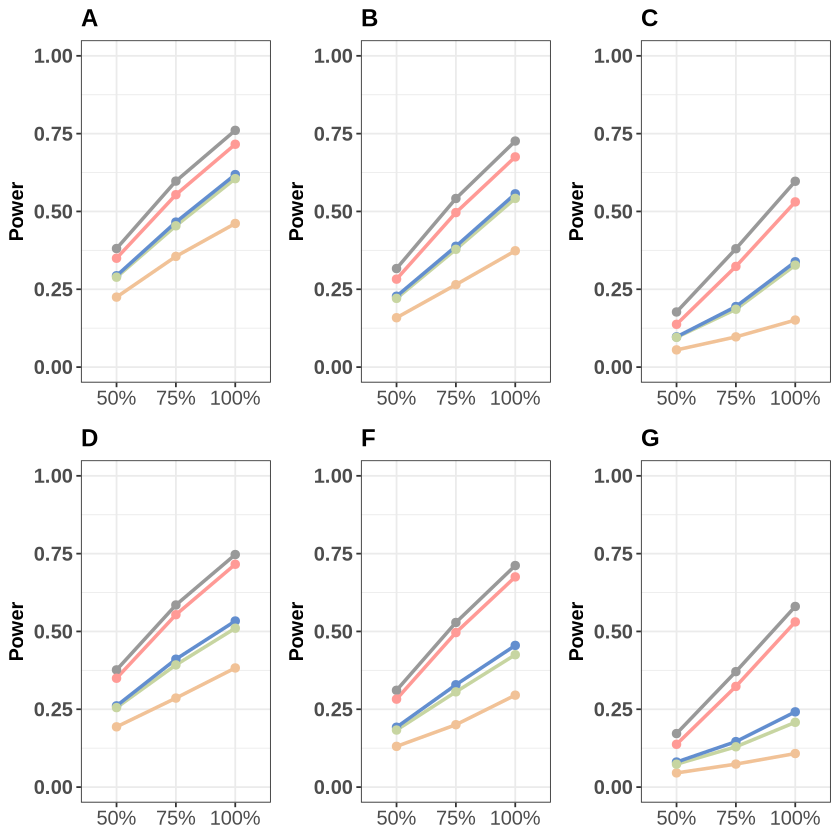

In [12]:
grid.arrange(rsq03_maf001_prev01, rsq03_maf0005_prev01, rsq03_maf0001_prev01, 
             rsq08_maf001_prev01, rsq08_maf0005_prev01, rsq08_maf0001_prev01, nrow = 2)

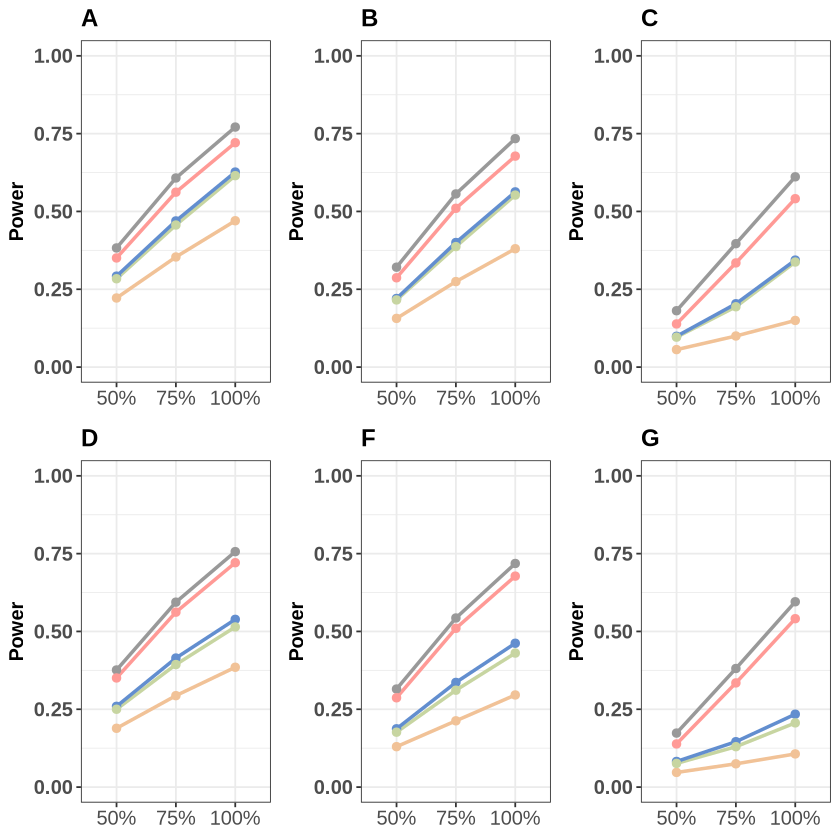

In [13]:
grid.arrange(rsq03_maf001_prev02, rsq03_maf0005_prev02, rsq03_maf0001_prev02, 
             rsq08_maf001_prev02, rsq08_maf0005_prev02, rsq08_maf0001_prev02, nrow = 2)

In [14]:
getwd()

[1] "/mnt/vast/hpc/csg/tl3031/git/imputation_brv/workflow/results"

In [15]:
jpeg(file="./power_prev01_maf001_0001.jpg", units="cm", width=21, height=27, res=300)
grid.arrange(rsq03_maf001_prev01, rsq03_maf0005_prev01, rsq03_maf0001_prev01, 
             rsq08_maf001_prev01, rsq08_maf0005_prev01, rsq08_maf0001_prev01, nrow = 2)
dev.off()

jpeg(file="./power_prev02_maf001_0001.jpg", units="cm", width=21, height=27, res=300)
grid.arrange(rsq03_maf001_prev02, rsq03_maf0005_prev02, rsq03_maf0001_prev02, 
             rsq08_maf001_prev02, rsq08_maf0005_prev02, rsq08_maf0001_prev02, nrow = 2)
dev.off()

png 
  2

png 
  2

## QQ-plots

In [16]:
setwd("~/project/git/imputation_brv/workflow/results/")

In [17]:
rsq03_maf001_exome_pval <- fread("rsq03_maf001_exome_result_type1e.csv")
rsq03_maf001_hrc_pval <- fread("rsq03_maf001_hrc_result_type1e.csv")
rsq03_maf001_topmed_pval <- fread("rsq03_maf001_topmed_result_type1e.csv")
rsq03_maf001_hrc_topmed_pval <- fread("rsq03_maf001_hrc_topmed_result_type1e.csv")
rsq03_maf001_hrc_topmed_exome_pval <- fread("rsq03_maf001_hrc_topmed_exome_result_type1e.csv")

rsq03_maf0005_exome_pval <- fread("rsq03_maf0005_exome_result_type1e.csv")
rsq03_maf0005_hrc_pval <- fread("rsq03_maf0005_hrc_result_type1e.csv")
rsq03_maf0005_topmed_pval <- fread("rsq03_maf0005_topmed_result_type1e.csv")
rsq03_maf0005_hrc_topmed_pval <- fread("rsq03_maf0005_hrc_topmed_result_type1e.csv")
rsq03_maf0005_hrc_topmed_exome_pval <- fread("rsq03_maf0005_hrc_topmed_exome_result_type1e.csv")

rsq03_maf0001_exome_pval <- fread("rsq03_maf0001_exome_result_type1e.csv")
rsq03_maf0001_hrc_pval <- fread("rsq03_maf0001_hrc_result_type1e.csv")
rsq03_maf0001_topmed_pval <- fread("rsq03_maf0001_topmed_result_type1e.csv")
rsq03_maf0001_hrc_topmed_pval <- fread("rsq03_maf0001_hrc_topmed_result_type1e.csv")
rsq03_maf0001_hrc_topmed_exome_pval <- fread("rsq03_maf0001_hrc_topmed_exome_result_type1e.csv")

In [18]:
rsq08_maf001_exome_pval <- fread("rsq08_maf001_exome_result_type1e.csv")
rsq08_maf001_hrc_pval <- fread("rsq08_maf001_hrc_result_type1e.csv")
rsq08_maf001_topmed_pval <- fread("rsq08_maf001_topmed_result_type1e.csv")
rsq08_maf001_hrc_topmed_pval <- fread("rsq08_maf001_hrc_topmed_result_type1e.csv")
rsq08_maf001_hrc_topmed_exome_pval <- fread("rsq08_maf001_hrc_topmed_exome_result_type1e.csv")

rsq08_maf0005_exome_pval <- fread("rsq08_maf0005_exome_result_type1e.csv")
rsq08_maf0005_hrc_pval <- fread("rsq08_maf0005_hrc_result_type1e.csv")
rsq08_maf0005_topmed_pval <- fread("rsq08_maf0005_topmed_result_type1e.csv")
rsq08_maf0005_hrc_topmed_pval <- fread("rsq08_maf0005_hrc_topmed_result_type1e.csv")
rsq08_maf0005_hrc_topmed_exome_pval <- fread("rsq08_maf0005_hrc_topmed_exome_result_type1e.csv")

rsq08_maf0001_exome_pval <- fread("rsq08_maf0001_exome_result_type1e.csv")
rsq08_maf0001_hrc_pval <- fread("rsq08_maf0001_hrc_result_type1e.csv")
rsq08_maf0001_topmed_pval <- fread("rsq08_maf0001_topmed_result_type1e.csv")
rsq08_maf0001_hrc_topmed_pval <- fread("rsq08_maf0001_hrc_topmed_result_type1e.csv")
rsq08_maf0001_hrc_topmed_exome_pval <- fread("rsq08_maf0001_hrc_topmed_exome_result_type1e.csv")

In [19]:
qqplot_generator_rsq03 <- function(exome_df, hrc_df, topmed_df, hrc_topmed_df, hrc_topmed_exome_df, prev_threshold, label){
    p1.sorted <- exome_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()
    p2.sorted <- hrc_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()
    p3.sorted <- topmed_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()
    p4.sorted <- hrc_topmed_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()
    p5.sorted <- hrc_topmed_exome_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()

    exome_df <- data.frame(exome_x = -log10(ppoints(p1.sorted)), exome_y = -log10(p1.sorted))
    hrc_df <- data.frame(hrc_x = -log10(ppoints(p2.sorted)), hrc_y = -log10(p2.sorted))
    topmed_df <- data.frame(topmed_x = -log10(ppoints(p3.sorted)), topmed_y = -log10(p3.sorted))
    hrc_topmed_df <- data.frame(hrc_topmed_x = -log10(ppoints(p4.sorted)), hrc_topmed_y = -log10(p4.sorted))
    hrc_topmed_exome_df <- data.frame(hrc_topmed_exome_x = -log10(ppoints(p5.sorted)), hrc_topmed_exome_y = -log10(p5.sorted))
    
    if(label == "A"){
        plt <- exome_df %>%
            ggplot(aes(x=exome_x, y=exome_y, color='Exome')) + geom_point() + geom_abline() +
            geom_point(data = hrc_df, aes(x=hrc_x, y=hrc_y, color="HRC")) +
            geom_point(data = topmed_df, aes(x=topmed_x, y=topmed_y, color="TOPMed")) +
            geom_point(data = hrc_topmed_df, aes(x=hrc_topmed_x, y=hrc_topmed_y, color="HRC + TOPMed")) +
            geom_point(data = hrc_topmed_exome_df, aes(x=hrc_topmed_exome_x, y=hrc_topmed_exome_y, 
                                                       color = "HRC + TOPMed + Exome")) +
            xlab("Expected -log10(p)") + ylab("Observed -log10(p)") + xlim(c(0, 4.5)) + ylim(c(0, 4.5)) +
            labs(title = label) +
            scale_color_manual(name = "Dataset", values = c("Exome" = "#999999", "HRC" = "#ff9a96", "TOPMed" = "#f1c297",
                                                           "HRC + TOPMed" = "#c7d5a1", "HRC + TOPMed + Exome" = "#628ecf")) +
            theme(panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank(),
                  panel.background = element_blank(), 
                  axis.line = element_line(colour = "black"),
                  legend.position = "",
                  legend.title = element_text(face = "bold"),
                  title = element_text(size=12,face="bold"),
                  axis.text = element_text(size=10),
                  axis.title = element_text(size=12,face="bold"),
                  axis.title.x = element_blank(),
                  plot.caption = element_text(hjust = 0, face="bold"))
        } else {
            plt <- exome_df %>%
            ggplot(aes(x=exome_x, y=exome_y, color='Exome')) + geom_point() + geom_abline() +
            geom_point(data = hrc_df, aes(x=hrc_x, y=hrc_y, color="HRC")) +
            geom_point(data = topmed_df, aes(x=topmed_x, y=topmed_y, color="TOPMed")) +
            geom_point(data = hrc_topmed_df, aes(x=hrc_topmed_x, y=hrc_topmed_y, color="HRC + TOPMed")) +
            geom_point(data = hrc_topmed_exome_df, aes(x=hrc_topmed_exome_x, y=hrc_topmed_exome_y, 
                                                       color = "HRC + TOPMed + Exome")) +
            xlab("Expected -log10(p)") + ylab("Observed -log10(p)") + xlim(c(0, 4.5)) + ylim(c(0, 4.5)) +
            labs(title = label) +
            scale_color_manual(name = "Dataset", values = c("Exome" = "#999999", "HRC" = "#ff9a96", "TOPMed" = "#f1c297",
                                                           "HRC + TOPMed" = "#c7d5a1", "HRC + TOPMed + Exome" = "#628ecf")) +
            theme(panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank(),
                  panel.background = element_blank(), 
                  axis.line = element_line(colour = "black"),
                  legend.position = "",
                  legend.title = element_text(face = "bold"),
                  title = element_text(size=12,face="bold"),
                  axis.text = element_text(size=10),
                  axis.title = element_text(size=12,face="bold"),
                  axis.title.x = element_blank(),
                  axis.title.y = element_blank(),
                  plot.caption = element_text(hjust = 0, face="bold"))
        }
        
    return(plt)
}

In [20]:
qqplot_generator_rsq08 <- function(exome_df, hrc_df, topmed_df, hrc_topmed_df, hrc_topmed_exome_df, prev_threshold, label){
    p1.sorted <- exome_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()
    p2.sorted <- hrc_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()
    p3.sorted <- topmed_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()
    p4.sorted <- hrc_topmed_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()
    p5.sorted <- hrc_topmed_exome_df %>% filter(prevlence == prev_threshold) %>% filter(pvals != 1) %>% pull(pvals) %>% as.numeric() %>% sort()

    exome_df <- data.frame(exome_x = -log10(ppoints(p1.sorted)), exome_y = -log10(p1.sorted))
    hrc_df <- data.frame(hrc_x = -log10(ppoints(p2.sorted)), hrc_y = -log10(p2.sorted))
    topmed_df <- data.frame(topmed_x = -log10(ppoints(p3.sorted)), topmed_y = -log10(p3.sorted))
    hrc_topmed_df <- data.frame(hrc_topmed_x = -log10(ppoints(p4.sorted)), hrc_topmed_y = -log10(p4.sorted))
    hrc_topmed_exome_df <- data.frame(hrc_topmed_exome_x = -log10(ppoints(p5.sorted)), hrc_topmed_exome_y = -log10(p5.sorted))
    # plt_df <- rbind(exome_df, hrc_df, topmed_df, hrc_topmed_df, hrc_topmed_exome_df)

    if(label == "D"){
        plt <- exome_df %>%
            ggplot(aes(x=exome_x, y=exome_y, color='Exome')) + geom_point() + geom_abline() +
            geom_point(data = hrc_df, aes(x=hrc_x, y=hrc_y, color="HRC")) +
            geom_point(data = topmed_df, aes(x=topmed_x, y=topmed_y, color="TOPMed")) +
            geom_point(data = hrc_topmed_df, aes(x=hrc_topmed_x, y=hrc_topmed_y, color="HRC + TOPMed")) +
            geom_point(data = hrc_topmed_exome_df, aes(x=hrc_topmed_exome_x, y=hrc_topmed_exome_y, 
                                                       color = "HRC + TOPMed + Exome")) +
            xlab("Expected -log10(p)") + ylab("Observed -log10(p)") + xlim(c(0, 4.5)) + ylim(c(0, 4.5)) +
            labs(title = label) +
            scale_color_manual(name = "Dataset", values = c("Exome" = "#999999", "HRC" = "#ff9a96", "TOPMed" = "#f1c297",
                                                           "HRC + TOPMed" = "#c7d5a1", "HRC + TOPMed + Exome" = "#628ecf")) +
            theme(panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank(),
                  panel.background = element_blank(), 
                  axis.line = element_line(colour = "black"),
                  legend.position = "",
                  legend.title = element_text(face = "bold"),
                  axis.text = element_text(size=10),
                  axis.title = element_text(size=12,face="bold"),
                  title = element_text(size=12,face="bold"),
                  plot.caption = element_text(hjust = 0, face="bold"))
    } else {
        plt <- exome_df %>%
            ggplot(aes(x=exome_x, y=exome_y, color='Exome')) + geom_point() + geom_abline() +
            geom_point(data = hrc_df, aes(x=hrc_x, y=hrc_y, color="HRC")) +
            geom_point(data = topmed_df, aes(x=topmed_x, y=topmed_y, color="TOPMed")) +
            geom_point(data = hrc_topmed_df, aes(x=hrc_topmed_x, y=hrc_topmed_y, color="HRC + TOPMed")) +
            geom_point(data = hrc_topmed_exome_df, aes(x=hrc_topmed_exome_x, y=hrc_topmed_exome_y, 
                                                       color = "HRC + TOPMed + Exome")) +
            xlab("Expected -log10(p)") + ylab("Observed -log10(p)") + xlim(c(0, 4.5)) + ylim(c(0, 4.5)) +
            labs(title = label) +
            scale_color_manual(name = "Dataset", values = c("Exome" = "#999999", "HRC" = "#ff9a96", "TOPMed" = "#f1c297",
                                                           "HRC + TOPMed" = "#c7d5a1", "HRC + TOPMed + Exome" = "#628ecf")) +
            theme(panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank(),
                  panel.background = element_blank(), 
                  axis.line = element_line(colour = "black"),
                  legend.position = "",
                  legend.title = element_text(face = "bold"),
                  axis.text = element_text(size=10),
                  axis.title = element_text(size=12,face="bold"),
                  axis.title.y = element_blank(),
                  title = element_text(size=12,face="bold"),
                  plot.caption = element_text(hjust = 0, face="bold"))
    }
        
    
    return(plt)
}

In [21]:
qq_rsq03_maf001 <- qqplot_generator_rsq03(rsq03_maf001_exome_pval, 
                                          rsq03_maf001_hrc_pval, 
                                          rsq03_maf001_topmed_pval, 
                                          rsq03_maf001_hrc_topmed_pval, 
                                          rsq03_maf001_hrc_topmed_exome_pval, 
                                          0.2, "A")

qq_rsq03_maf0005 <- qqplot_generator_rsq03(rsq03_maf0005_exome_pval, 
                                           rsq03_maf0005_hrc_pval, 
                                           rsq03_maf0005_topmed_pval, 
                                           rsq03_maf0005_hrc_topmed_pval, 
                                           rsq03_maf0005_hrc_topmed_exome_pval, 
                                           0.2, "B")

qq_rsq03_maf0001 <- qqplot_generator_rsq03(rsq03_maf0001_exome_pval, 
                                           rsq03_maf0001_hrc_pval, 
                                           rsq03_maf0001_topmed_pval, 
                                           rsq03_maf0001_hrc_topmed_pval, 
                                           rsq03_maf0001_hrc_topmed_exome_pval, 
                                           0.2, "C")

In [22]:
qq_rsq08_maf001 <- qqplot_generator_rsq08(rsq08_maf001_exome_pval, 
                                          rsq08_maf001_hrc_pval, 
                                          rsq08_maf001_topmed_pval, 
                                          rsq08_maf001_hrc_topmed_pval, 
                                          rsq08_maf001_hrc_topmed_exome_pval, 
                                          0.2, "D")

qq_rsq08_maf0005 <- qqplot_generator_rsq08(rsq08_maf0005_exome_pval, 
                                           rsq08_maf0005_hrc_pval, 
                                           rsq08_maf0005_topmed_pval, 
                                           rsq08_maf0005_hrc_topmed_pval, 
                                           rsq08_maf0005_hrc_topmed_exome_pval, 
                                           0.2, "E")

qq_rsq08_maf0001 <- qqplot_generator_rsq08(rsq08_maf0001_exome_pval, 
                                           rsq08_maf0001_hrc_pval, 
                                           rsq08_maf0001_topmed_pval, 
                                           rsq08_maf0001_hrc_topmed_pval, 
                                           rsq08_maf0001_hrc_topmed_exome_pval, 
                                           0.2, "F")

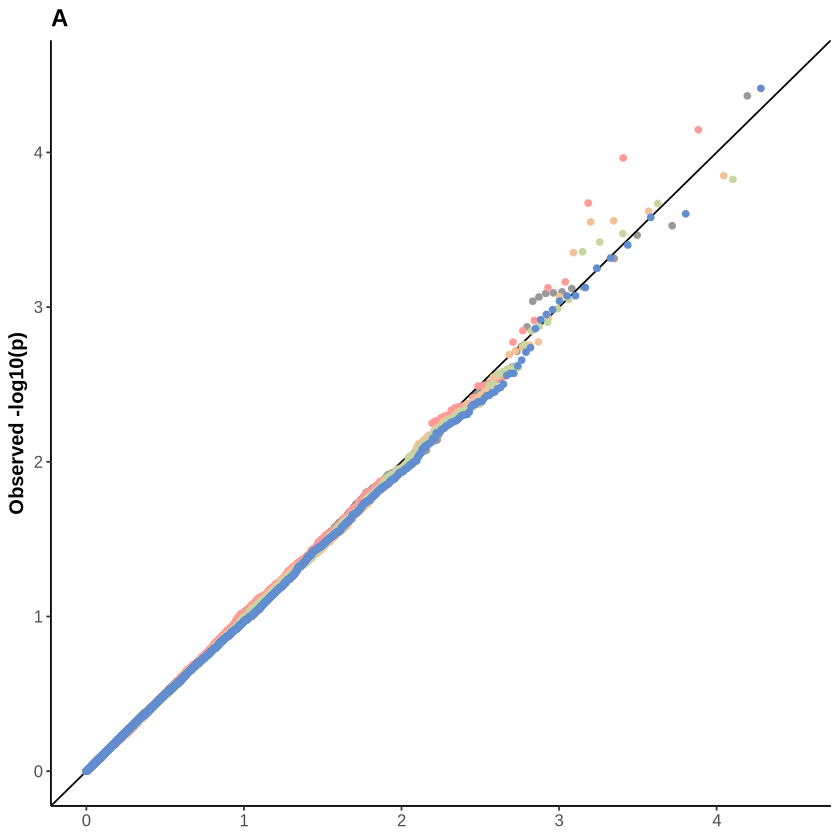

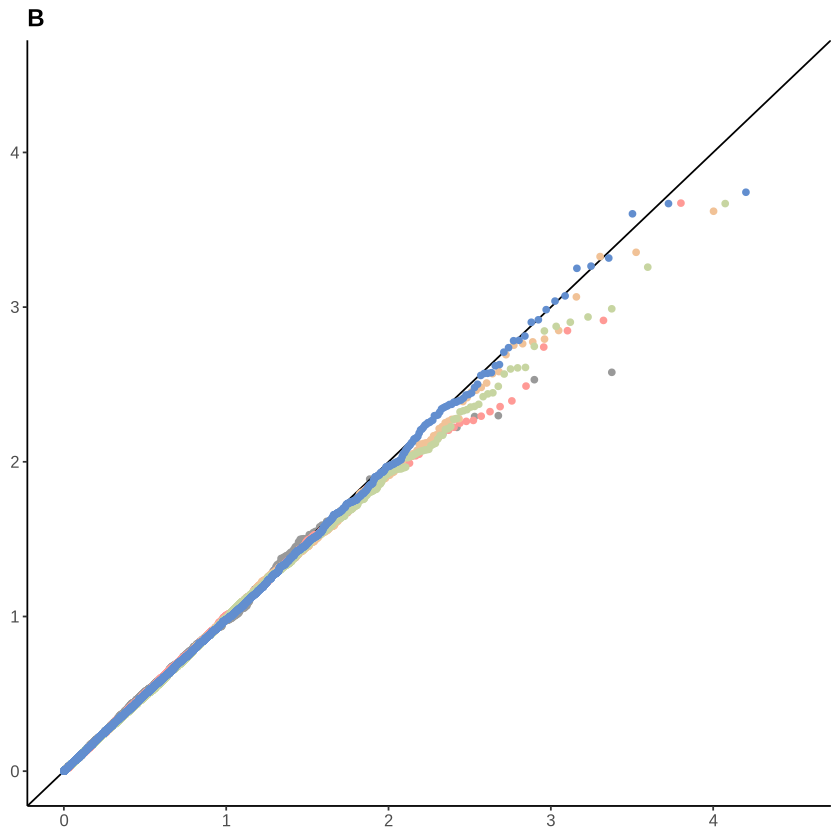

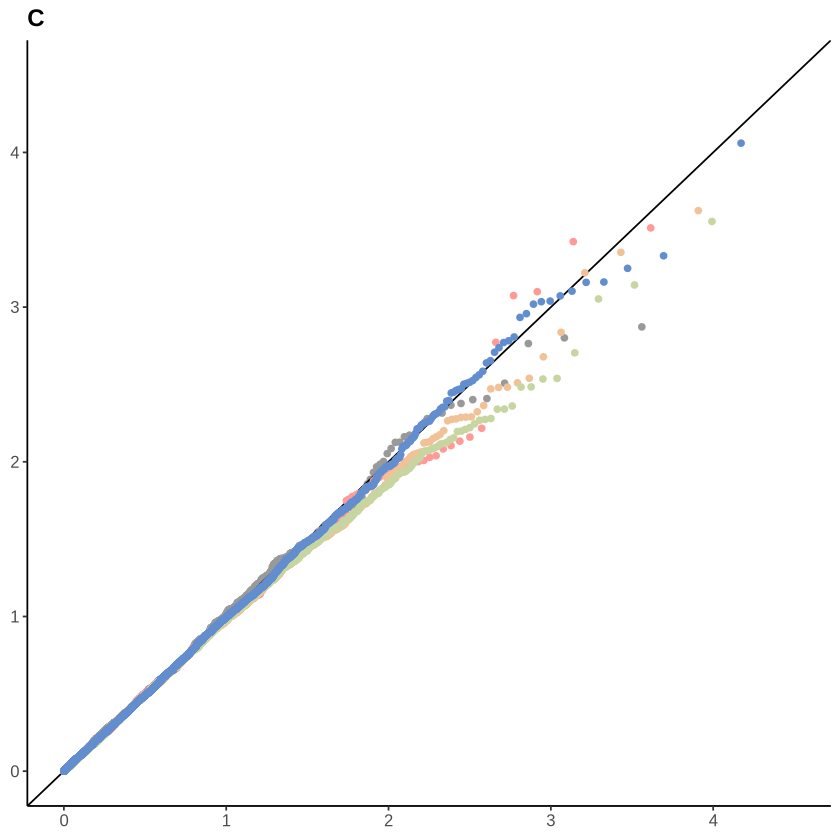

In [23]:
qq_rsq03_maf001
qq_rsq03_maf0005
qq_rsq03_maf0001

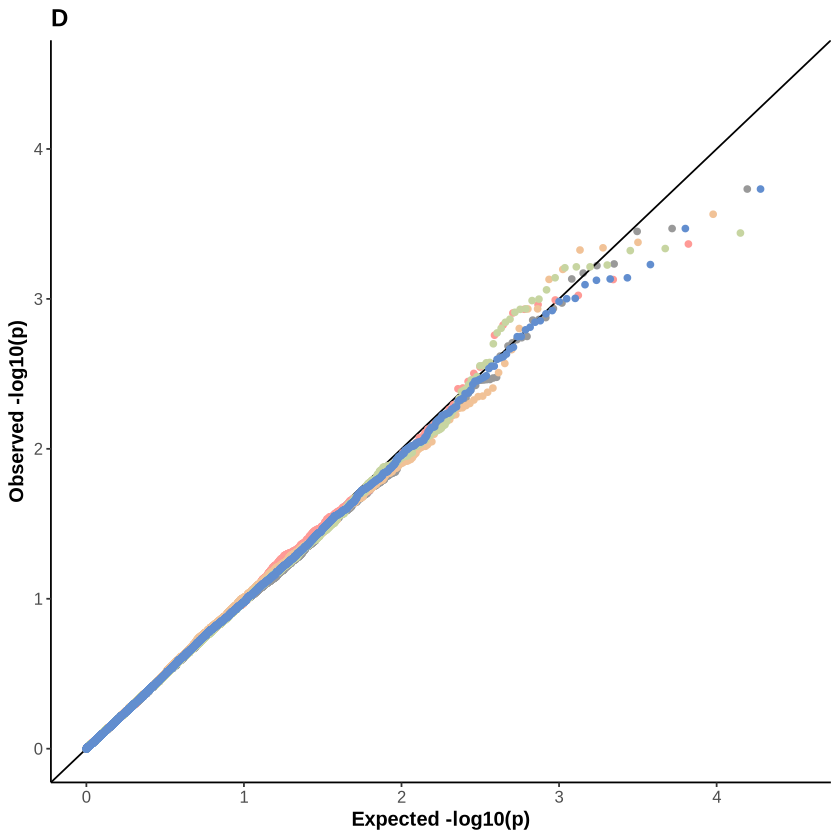

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


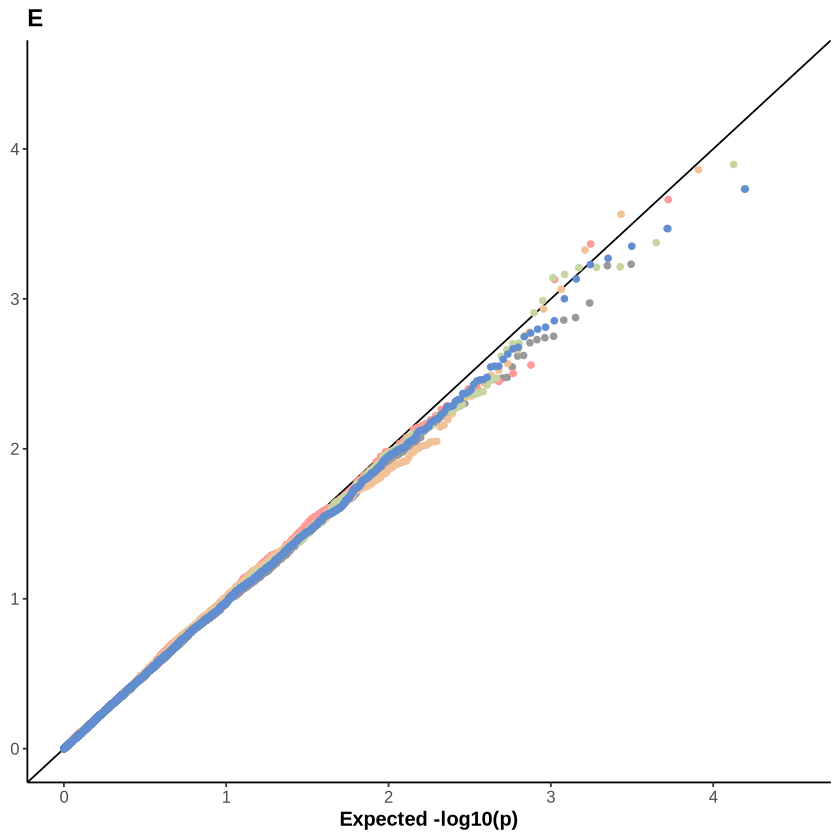

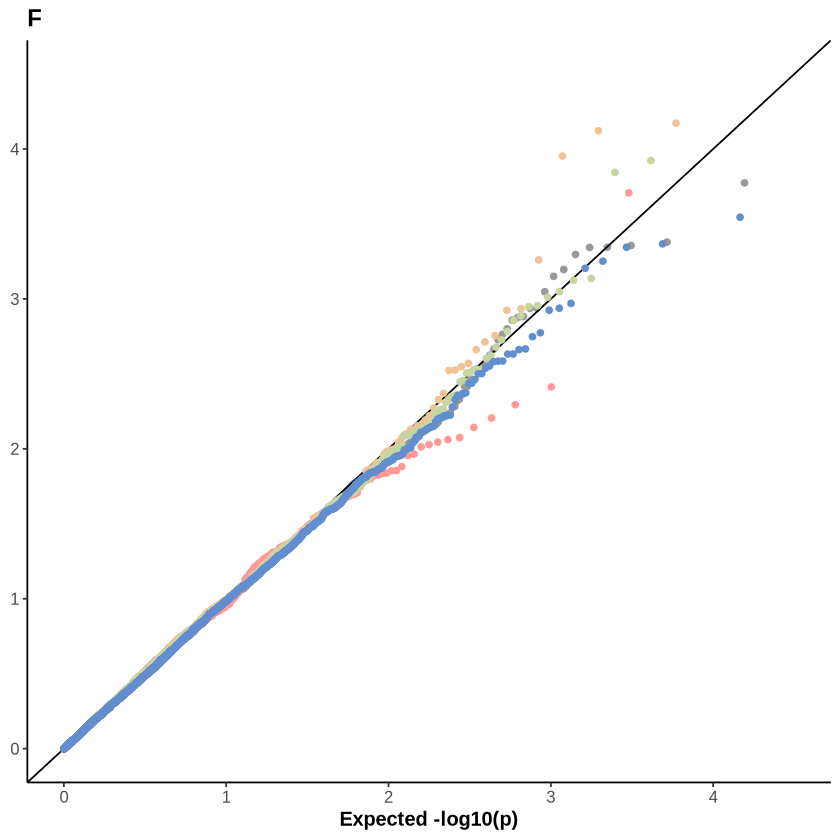

In [24]:
qq_rsq08_maf001
qq_rsq08_maf0005
qq_rsq08_maf0001

In [25]:
jpeg(file="./type1error_maf001_0001.jpg", units="cm", width=27, height=21, res=300)
grid.arrange(qq_rsq03_maf001, qq_rsq03_maf0005, qq_rsq03_maf0001, 
             qq_rsq08_maf001, qq_rsq08_maf0005, qq_rsq08_maf0001, nrow = 2)
dev.off()

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


png 
  2